Reproducing rolling window test for stock data.

In [119]:
import sys
import os
sys.path.append(os.path.abspath("D:\\Python\\commodity_futures_price"))

import math

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# %load_ext autoreload
# %autoreload 2
%reload_ext autoreload
from model.savvy_sh import SavvySh

In [120]:
data = pd.read_csv('../../data/processed_stock/cleaned_AAPL.csv', index_col=0, parse_dates=True).dropna()
raw_y = data["Close"]
raw_X = data[["MOM_vol_adj", "Skewness", "Volatility", "Op_Int", "Value_BM"]]

In [121]:
y = raw_y.pct_change().shift(-1).dropna()
X = raw_X.iloc[:-1]

### EDA

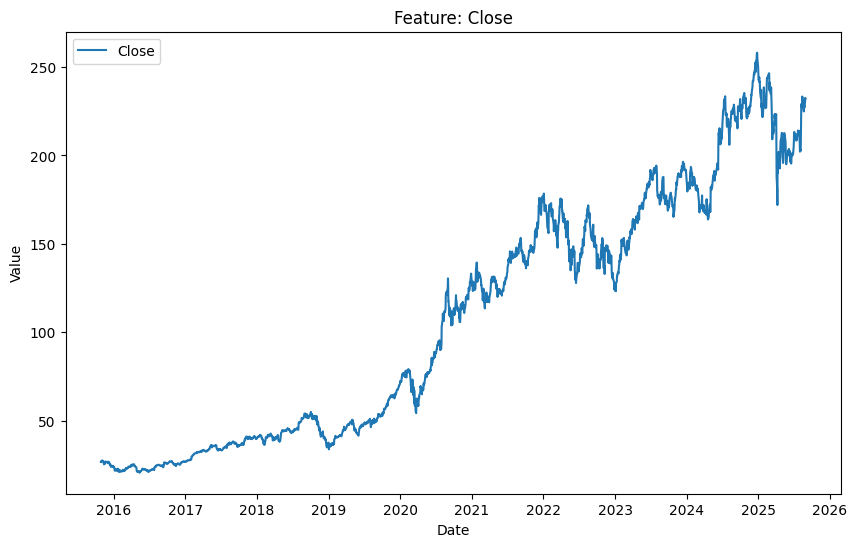

In [122]:
plt.figure(figsize=(10, 6))
plt.plot(raw_y.index, raw_y, label="Close")
plt.title(f"Feature: Close")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.show()

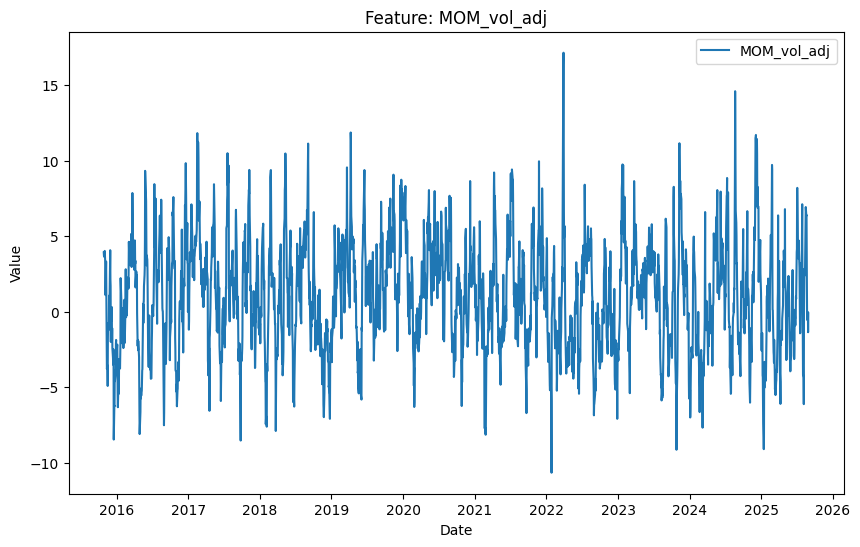

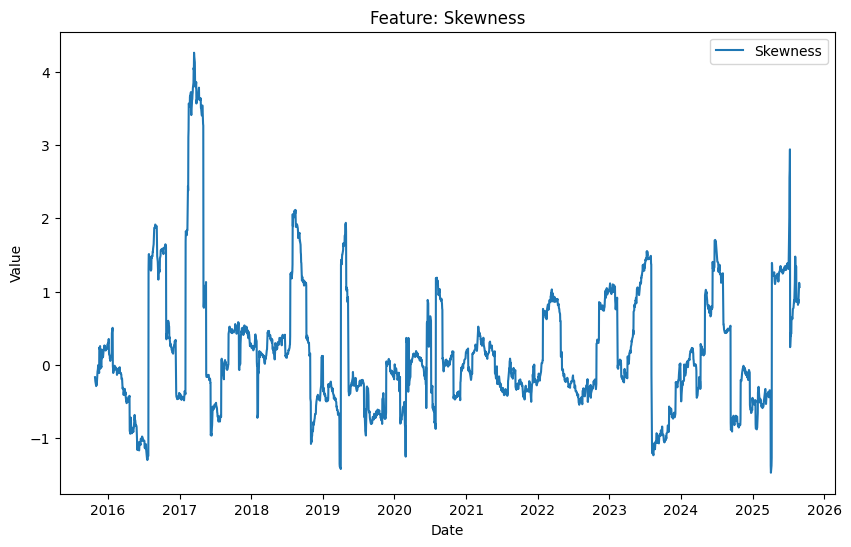

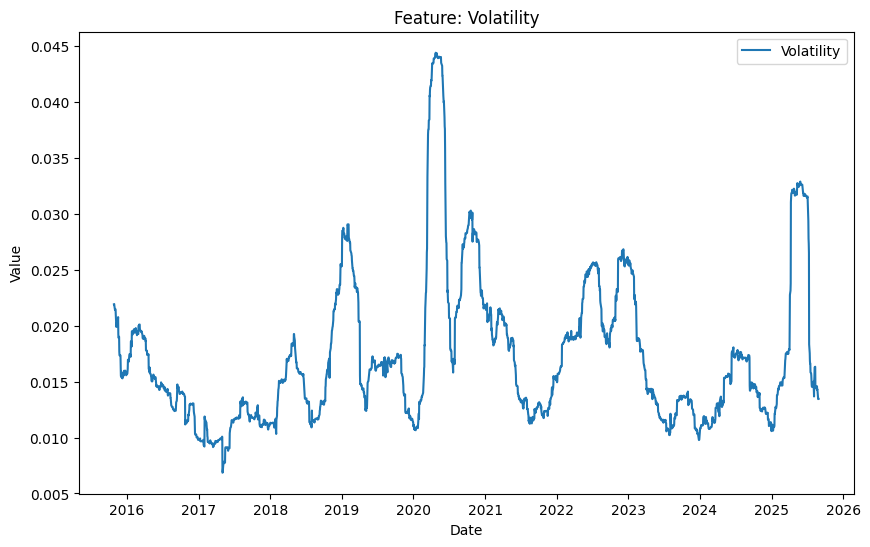

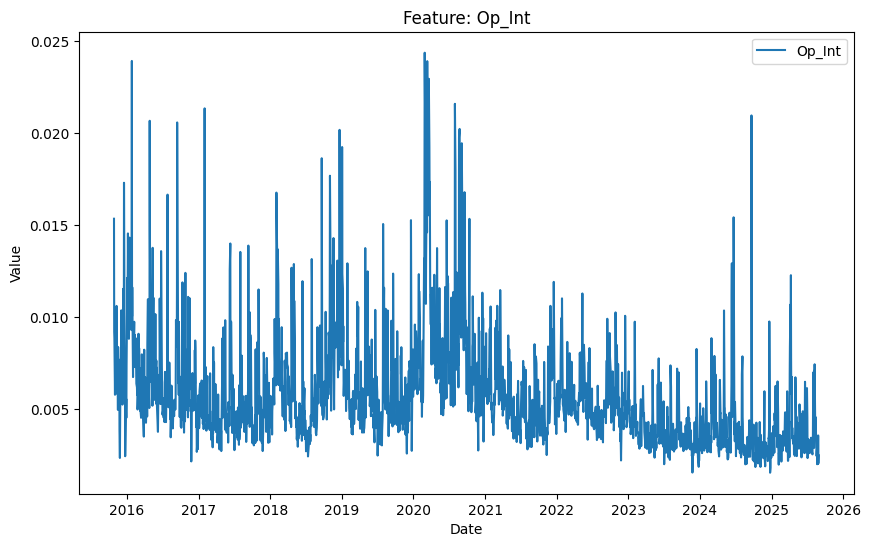

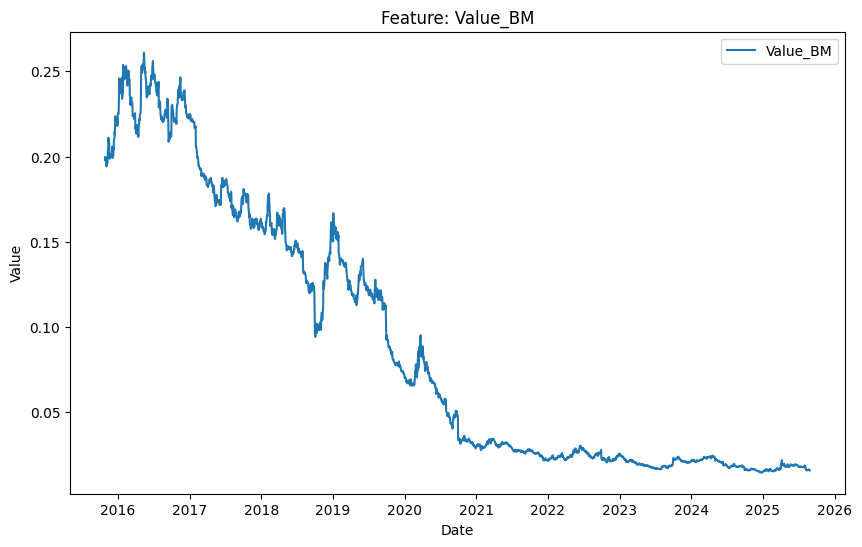

In [123]:
# plot each factor
for col in X.columns:
    plt.figure(figsize=(10, 6))
    plt.plot(X.index, X[col], label=col)
    plt.title(f"Feature: {col}")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

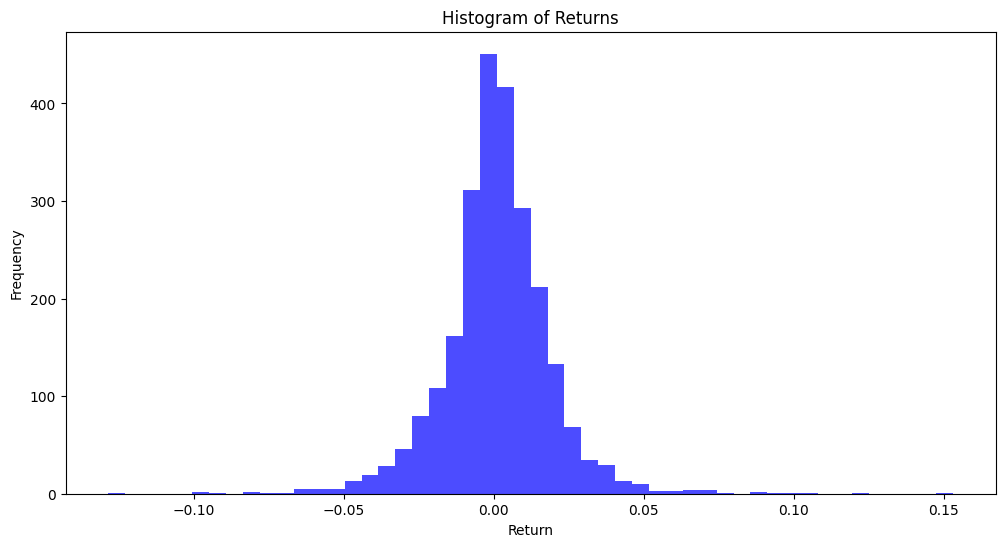

In [124]:
# plot the histogram of y
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.hist(y, bins=50, alpha=0.7, color='blue')
plt.title('Histogram of Returns')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.show()

In [125]:
len_ = data.shape[0]
train_size = 252 # one year
test_size = 21 # one month

start_end_list = []
start = 0
while(start < len_ - train_size - test_size):
    end = start + train_size + test_size - 1
    start_end_list.append((start, end))
    start = start + test_size

### Rolling Window Prediction

In [126]:
strategies = ["OLS", "Stein", "DSh", "Sh", "SR", "GSR", "LSh", "SRR"]
mse_by_time = {strat: [] for strat in strategies}

for start, end in start_end_list:
    for strat in strategies:
        train_X, train_y = X.iloc[start:end - test_size + 1], y.iloc[start:end - test_size + 1]
        test_X, test_y = X.iloc[end - test_size + 1:end + 1], y.iloc[end - test_size + 1:end + 1]

        scaler = StandardScaler()
        train_X = scaler.fit_transform(train_X)
        test_X = scaler.transform(test_X)

        if strat == "OLS":
            ols = LinearRegression()
            ols.fit(train_X, train_y)
            predict = ols.predict(test_X)
        elif strat == "LSh":
            model_linear = SavvySh(model_class="Linear")
            model_linear.fit(train_X, train_y)
            predict = model_linear.predict(test_X)["LSh"]
        elif strat == "SRR":
            model_shrinkage_ridge = SavvySh(model_class="ShrinkageRR")
            model_shrinkage_ridge.fit(train_X, train_y)
            predict = model_shrinkage_ridge.predict(test_X)["SRR"]
        elif strat in ["SR", "GSR"]:
            model_slab = SavvySh(model_class="Slab")
            model_slab.fit(train_X, train_y)
            tmp_pred = model_slab.predict(test_X)
            if strat == "SR":
                predict = tmp_pred["SR"]
            else:
                predict = tmp_pred["GSR"]
        else:
            model_mult = SavvySh(model_class="Multiplicative", include_Sh=True)
            model_mult.fit(train_X, train_y)
            tmp_pred = model_mult.predict(test_X)
            if strat == "Stein":
                predict = tmp_pred["St"]
            elif strat == "DSh":
                predict = tmp_pred["DSh"]
            else:
                predict = tmp_pred["Sh"]
        mse = mean_squared_error(test_y, predict)
        mse_by_time[strat].append(mse)

        # print(mse / np.var(train_y, ddof=1))

In [127]:
for strat, mses in mse_by_time.items():
    print("Strategy:", strat)
    print("Mean Squared Errors:", np.mean(mses))
    print("MSE / Var:", np.mean(mses) / np.var(y, ddof=1))

Strategy: OLS
Mean Squared Errors: 0.00038799777421170007
MSE / Var: 1.1459807235975792
Strategy: Stein
Mean Squared Errors: 0.0003720583661935746
MSE / Var: 1.0989024784415593
Strategy: DSh
Mean Squared Errors: 0.0003777318730625251
MSE / Var: 1.1156596093818731
Strategy: Sh
Mean Squared Errors: 0.00035252509363075047
MSE / Var: 1.0412094829823628
Strategy: SR
Mean Squared Errors: 0.00038736079060637345
MSE / Var: 1.1440993444210232
Strategy: GSR
Mean Squared Errors: 0.00046196997447453785
MSE / Var: 1.3644632026673151
Strategy: LSh
Mean Squared Errors: 0.0003877882980950748
MSE / Var: 1.1453620200697192
Strategy: SRR
Mean Squared Errors: 0.0003836974890594478
MSE / Var: 1.1332795066886256


### OLS

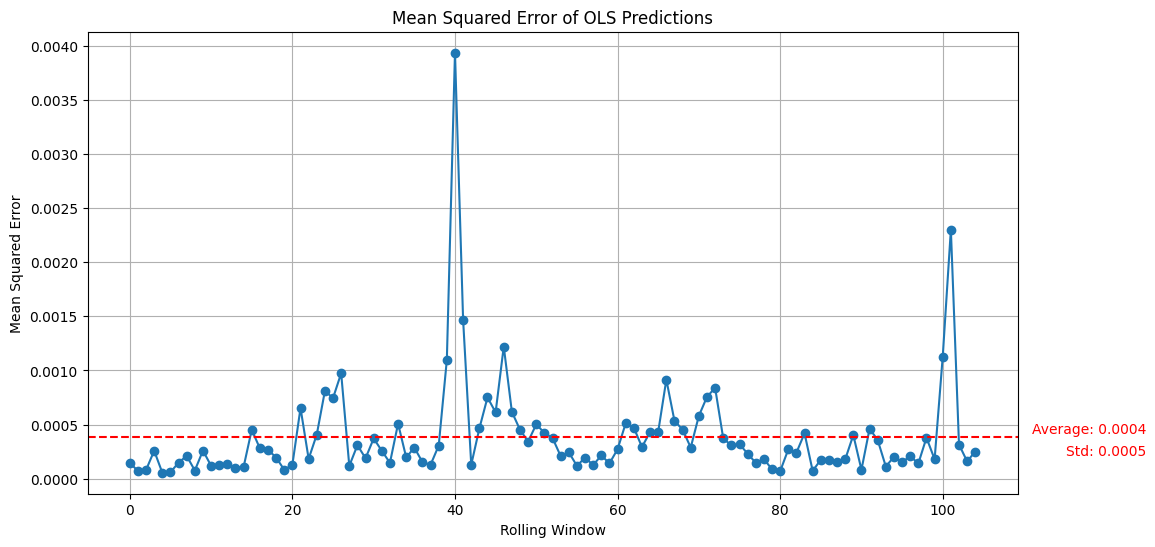

In [128]:
ols_mse_by_time = mse_by_time["OLS"]
# plot the mse
plt.figure(figsize=(12, 6))
plt.plot(ols_mse_by_time, marker='o')
plt.axhline(y=np.mean(ols_mse_by_time), color='r', linestyle='--')
plt.text(len(ols_mse_by_time) + 20, np.mean(ols_mse_by_time), f"Average: {np.mean(ols_mse_by_time):.4f}", color='r', ha='right', va='bottom')
# add std of mse
plt.text(len(ols_mse_by_time) + 20, np.mean(ols_mse_by_time) - 0.0002, f"Std: {np.std(ols_mse_by_time):.4f}", color='r', ha='right', va='bottom')
plt.title("Mean Squared Error of OLS Predictions")
plt.xlabel("Rolling Window")
plt.ylabel("Mean Squared Error")
plt.grid()
plt.show()

### Stein

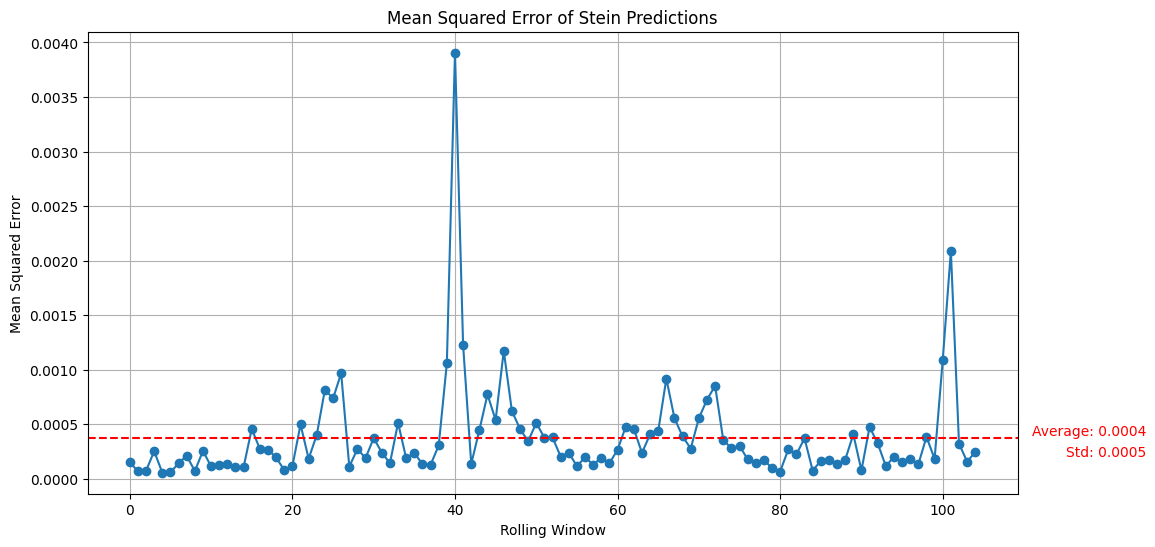

In [129]:
stein_mse_by_time = mse_by_time["Stein"]
# plot the mse
plt.figure(figsize=(12, 6))
plt.plot(stein_mse_by_time, marker='o')
plt.axhline(y=np.mean(stein_mse_by_time), color='r', linestyle='--')
plt.text(len(stein_mse_by_time) + 20, np.mean(stein_mse_by_time), f"Average: {np.mean(stein_mse_by_time):.4f}", color='r', ha='right', va='bottom')
# add std of mse
plt.text(len(stein_mse_by_time) + 20, np.mean(stein_mse_by_time) - 0.0002, f"Std: {np.std(stein_mse_by_time):.4f}", color='r', ha='right', va='bottom')
plt.title("Mean Squared Error of Stein Predictions")
plt.xlabel("Rolling Window")
plt.ylabel("Mean Squared Error")
plt.grid()
plt.show()

### DSh

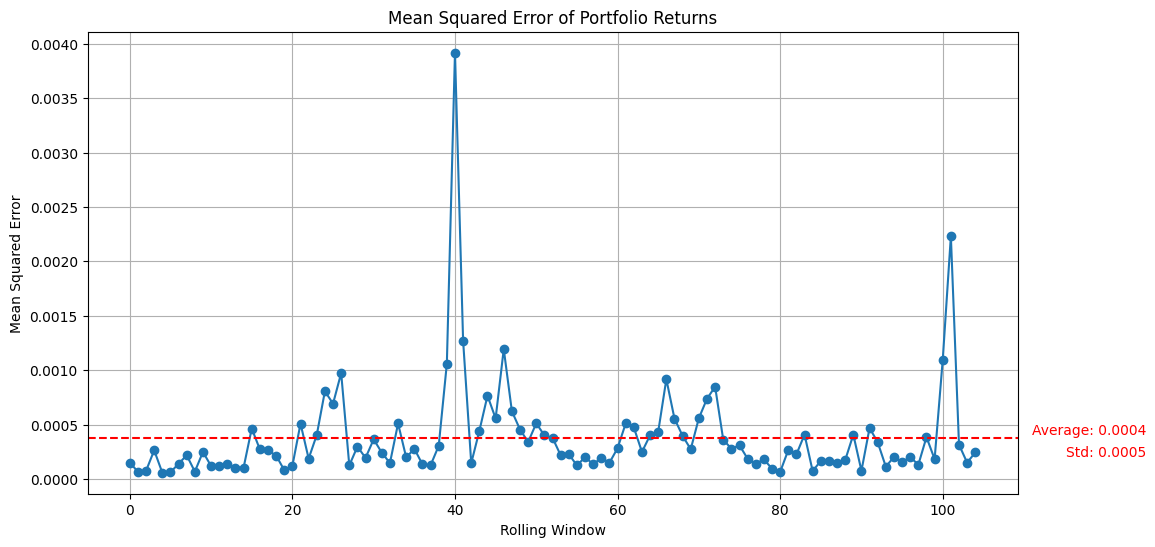

In [130]:
DSh_mse_by_time = mse_by_time["DSh"]
# plot the mse
plt.figure(figsize=(12, 6))
plt.plot(DSh_mse_by_time, marker='o')
plt.axhline(y=np.mean(DSh_mse_by_time), color='r', linestyle='--')
plt.text(len(DSh_mse_by_time) + 20, np.mean(DSh_mse_by_time), f"Average: {np.mean(DSh_mse_by_time):.4f}", color='r', ha='right', va='bottom')
# add std of mse
plt.text(len(DSh_mse_by_time) + 20, np.mean(DSh_mse_by_time) - 0.0002, f"Std: {np.std(DSh_mse_by_time):.4f}", color='r', ha='right', va='bottom')
plt.title("Mean Squared Error of Portfolio Returns")
plt.xlabel("Rolling Window")
plt.ylabel("Mean Squared Error")
plt.grid()
plt.show()

### Sh

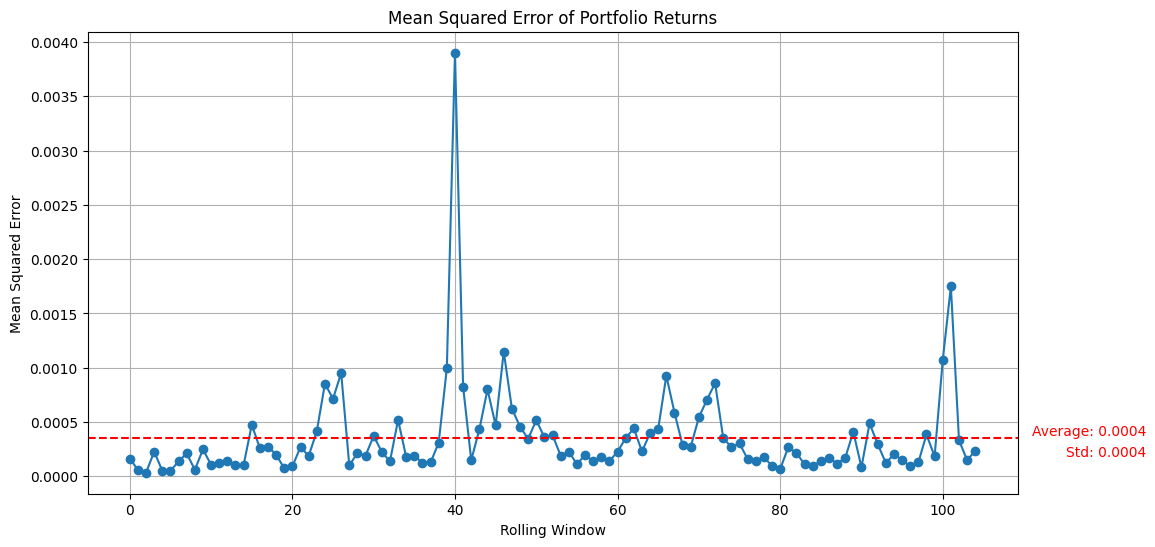

In [131]:
Sh_mse_by_time = mse_by_time["Sh"]
# plot the mse
plt.figure(figsize=(12, 6))
plt.plot(Sh_mse_by_time, marker='o')
plt.axhline(y=np.mean(Sh_mse_by_time), color='r', linestyle='--')
plt.text(len(Sh_mse_by_time) + 20, np.mean(Sh_mse_by_time), f"Average: {np.mean(Sh_mse_by_time):.4f}", color='r', ha='right', va='bottom')
# add std of mse
plt.text(len(Sh_mse_by_time) + 20, np.mean(Sh_mse_by_time) - 0.0002, f"Std: {np.std(Sh_mse_by_time):.4f}", color='r', ha='right', va='bottom')
plt.title("Mean Squared Error of Portfolio Returns")
plt.xlabel("Rolling Window")
plt.ylabel("Mean Squared Error")
plt.grid()
plt.show()

### Linear Shrinkage

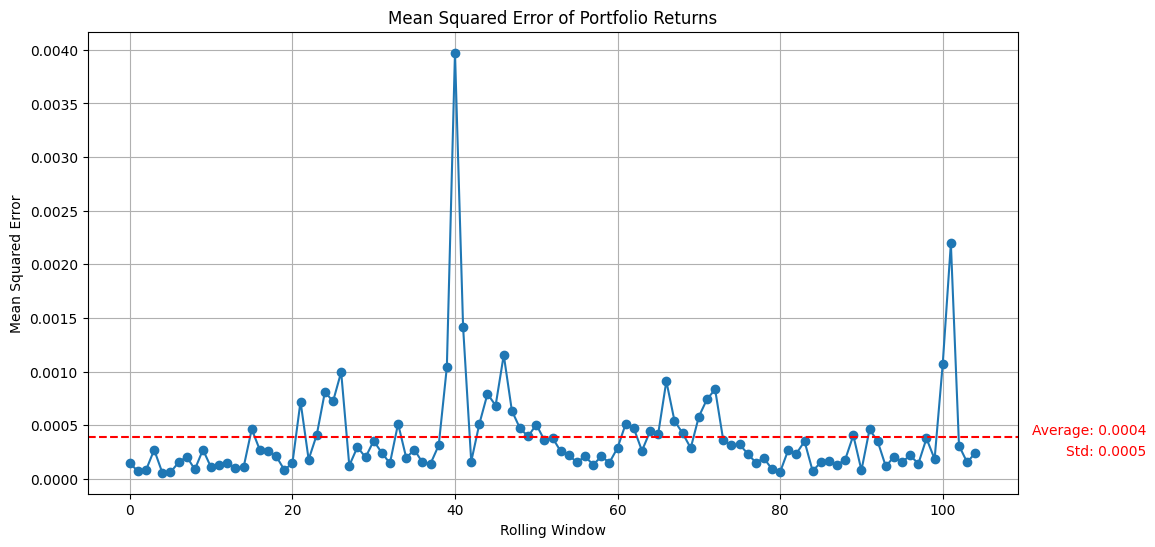

In [132]:
LSh_mse_by_time = mse_by_time["LSh"]
# plot the mse
plt.figure(figsize=(12, 6))
plt.plot(LSh_mse_by_time, marker='o')
plt.axhline(y=np.mean(LSh_mse_by_time), color='r', linestyle='--')
plt.text(len(LSh_mse_by_time) + 20, np.mean(LSh_mse_by_time), f"Average: {np.mean(LSh_mse_by_time):.4f}", color='r', ha='right', va='bottom')
# add std of mse
plt.text(len(LSh_mse_by_time) + 20, np.mean(LSh_mse_by_time) - 0.0002, f"Std: {np.std(LSh_mse_by_time):.4f}", color='r', ha='right', va='bottom')
plt.title("Mean Squared Error of Portfolio Returns")
plt.xlabel("Rolling Window")
plt.ylabel("Mean Squared Error")
plt.grid()
plt.show()

### Slab

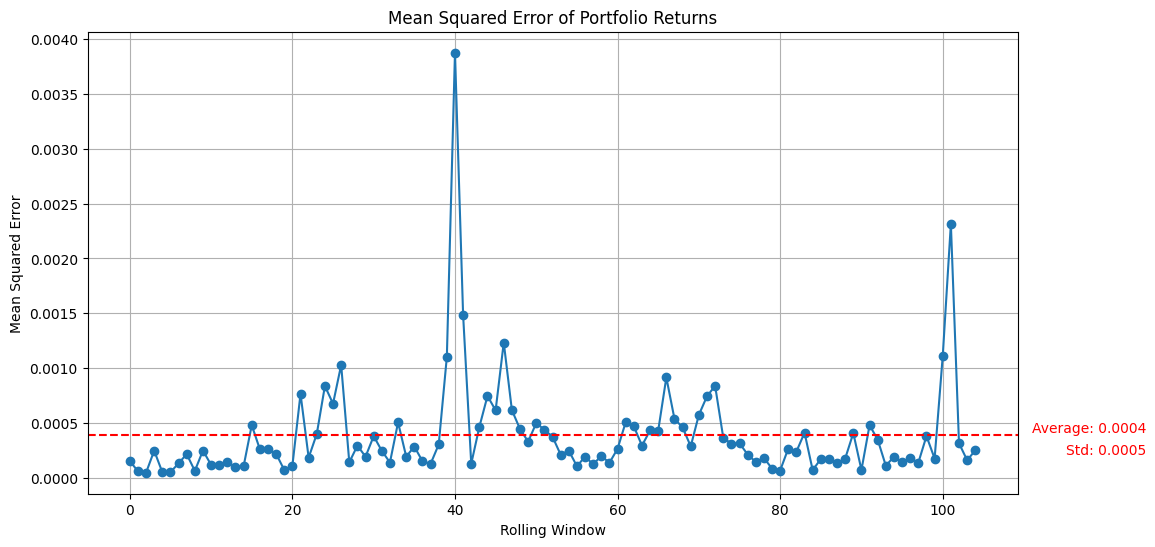

In [133]:
SR_mse_by_time = mse_by_time["SR"]
# plot the mse
plt.figure(figsize=(12, 6))
plt.plot(SR_mse_by_time, marker='o')
plt.axhline(y=np.mean(SR_mse_by_time), color='r', linestyle='--')
plt.text(len(SR_mse_by_time) + 20, np.mean(SR_mse_by_time), f"Average: {np.mean(SR_mse_by_time):.4f}", color='r', ha='right', va='bottom')
# add std of mse
plt.text(len(SR_mse_by_time) + 20, np.mean(SR_mse_by_time) - 0.0002, f"Std: {np.std(SR_mse_by_time):.4f}", color='r', ha='right', va='bottom')
plt.title("Mean Squared Error of Portfolio Returns")
plt.xlabel("Rolling Window")
plt.ylabel("Mean Squared Error")
plt.grid()
plt.show()

### Generalized Slab

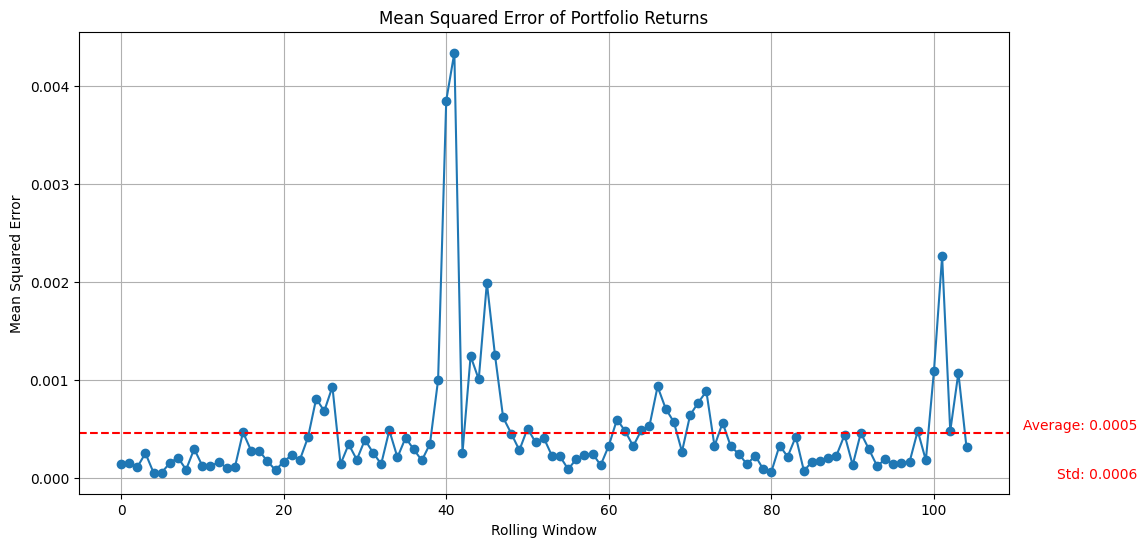

In [134]:
GSR_mse_by_time = mse_by_time["GSR"]
# plot the mse
plt.figure(figsize=(12, 6))
plt.plot(GSR_mse_by_time, marker='o')
plt.axhline(y=np.mean(GSR_mse_by_time), color='r', linestyle='--')
plt.text(len(GSR_mse_by_time) + 20, np.mean(GSR_mse_by_time), f"Average: {np.mean(GSR_mse_by_time):.4f}", color='r', ha='right', va='bottom')
# add std of mse
plt.text(len(GSR_mse_by_time) + 20, np.mean(GSR_mse_by_time) - 0.0005, f"Std: {np.std(GSR_mse_by_time):.4f}", color='r', ha='right', va='bottom')
plt.title("Mean Squared Error of Portfolio Returns")
plt.xlabel("Rolling Window")
plt.ylabel("Mean Squared Error")
plt.grid()
plt.show()

### Shrinkage Ridge

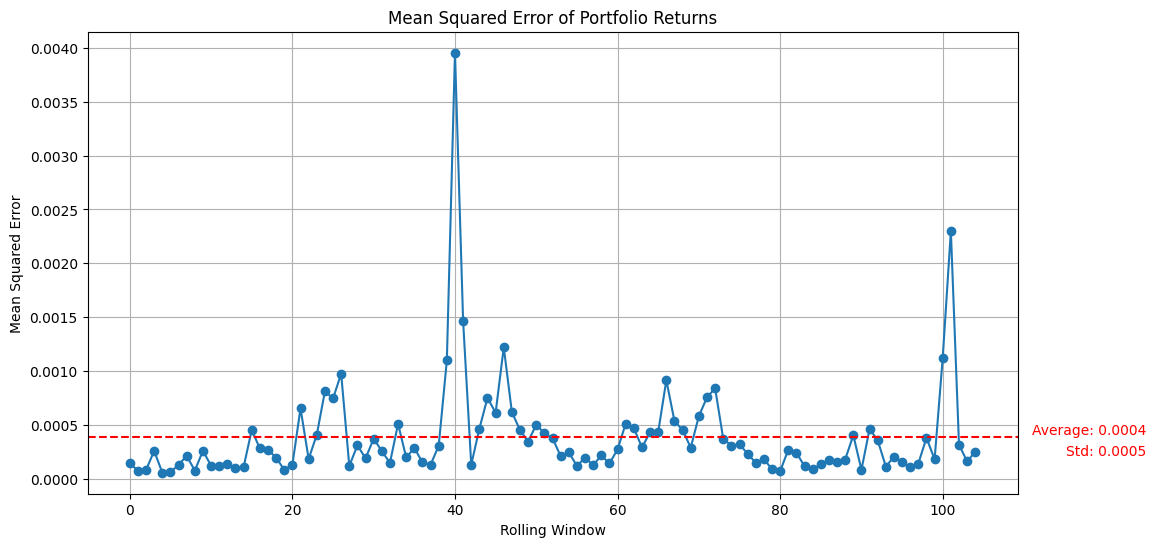

In [135]:
SRR_mse_by_time = mse_by_time["SRR"]
# plot the mse
plt.figure(figsize=(12, 6))
plt.plot(SRR_mse_by_time, marker='o')
plt.axhline(y=np.mean(SRR_mse_by_time), color='r', linestyle='--')
plt.text(len(SRR_mse_by_time) + 20, np.mean(SRR_mse_by_time), f"Average: {np.mean(SRR_mse_by_time):.4f}", color='r', ha='right', va='bottom')
# add std of mse
plt.text(len(SRR_mse_by_time) + 20, np.mean(SRR_mse_by_time) - 0.0002, f"Std: {np.std(SRR_mse_by_time):.4f}", color='r', ha='right', va='bottom')
plt.title("Mean Squared Error of Portfolio Returns")
plt.xlabel("Rolling Window")
plt.ylabel("Mean Squared Error")
plt.grid()
plt.show()